In [1]:
from correction.data.my_dataloader import WRFDataset, custom_collate, find_files
from correction.models.loss import TurbulentMSE
from correction.data.train_test_split import split_train_val_test
from correction.config.config import cfg
from correction.models.changeToERA5 import MeanToERA5
from correction.helpers.interpolation import InvDistTree
from correction.helpers.plot_utils import arcs
from correction.helpers import plot_utils
from torch.utils.data import DataLoader
import torch.nn as nn
import scipy
import matplotlib.pyplot as plt
import numpy as np
import pickle
from matplotlib import colors
import matplotlib
import torch
import xarray as xr
import pendulum as pdl

from datetime import datetime
import pickle
from correction.data.train_test_split import find_files
import matplotlib.pyplot as plt
import numpy as np
import pendulum as pdl
import torch

Device is: cuda
Running script on local machine
1 draw plots
1 use spt encoding
1 weighted meaner
gauss loss_kernel


In [2]:
batch_size = 32
wrf_vars = ['uvmet10', 'T2']
era_vars=['u10', 'v10', 't2m']
wrf_folder = 'C:\\Users\\Viktor\\Desktop\\wrf_test'
era_folder = 'C:\\Users\\Viktor\\Desktop\\era_test'
# wrf_folder1 = 'C:\\Users\\Viktor\\Desktop\\wrf2gpn_test\\t2'
scatter_file = ['scatter/cmems_obs-wind_glo_phy_nrt_l3-metopb-ascat-asc-0.125deg_P1D-i_multi-vars_22.31E-75.94E_62.31N-78.69N_2019-01-01-2023-10-11.nc',
                'scatter/cmems_obs-wind_glo_phy_nrt_l3-metopb-ascat-des-0.125deg_P1D-i_multi-vars_22.31E-75.94E_62.31N-78.69N_2019-01-01-2023-10-11.nc']
stations_folder = 'stations'
station_files = find_files(stations_folder, '*') 

In [3]:
train_files, val_files, test_files = split_train_val_test(wrf_folder, era_folder, 0.7, 0.1, 0.2)

C:/Users/Viktor/Desktop/wrf_test/wrfout_d01_2019-01-01_000000 C:/Users/Viktor/Desktop/wrf_test/wrfout_d01_2019-01-02_000000 - wrf border dates
Using dates from 2019-01-01 to 2019-01-02


In [4]:
train_dataset = WRFDataset(train_files[0], train_files[1], station_files=station_files, scatter_files=scatter_file, use_spatiotemporal_encoding=False, use_time_encoding=False)
dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=custom_collate, num_workers=0)

2 wrf_files length
2 era_files length
(48, 46, 4) 2019-01-01T00:00:00+00:00 2019-01-02T23:00:00+00:00 stations dates range
0 2 scatter slices
Zeros in indices!
0.013888888888888892 sigma_squared
Zeros in indices!
0.013888888888888892 sigma_squared
0.6132274385133707 ======================= orig u scatter mean
-7.337604850716491 ======================= orig v scatter mean
(2, 2, 4, 132, 430) scatter data shape


In [5]:
wrf, era, st_sample, scatter, i = next(iter(dataloader))

In [6]:
metadata = train_dataset.metadata
coords = metadata['coords']
metadata['era_xx'].shape

(67, 215)

({'scatterometer_era_2019-01-01': <Figure size 1920x1440 with 2 Axes>},
 <AxesSubplot: >,
 <mpl_toolkits.basemap.Basemap at 0x1c840e2cd30>)

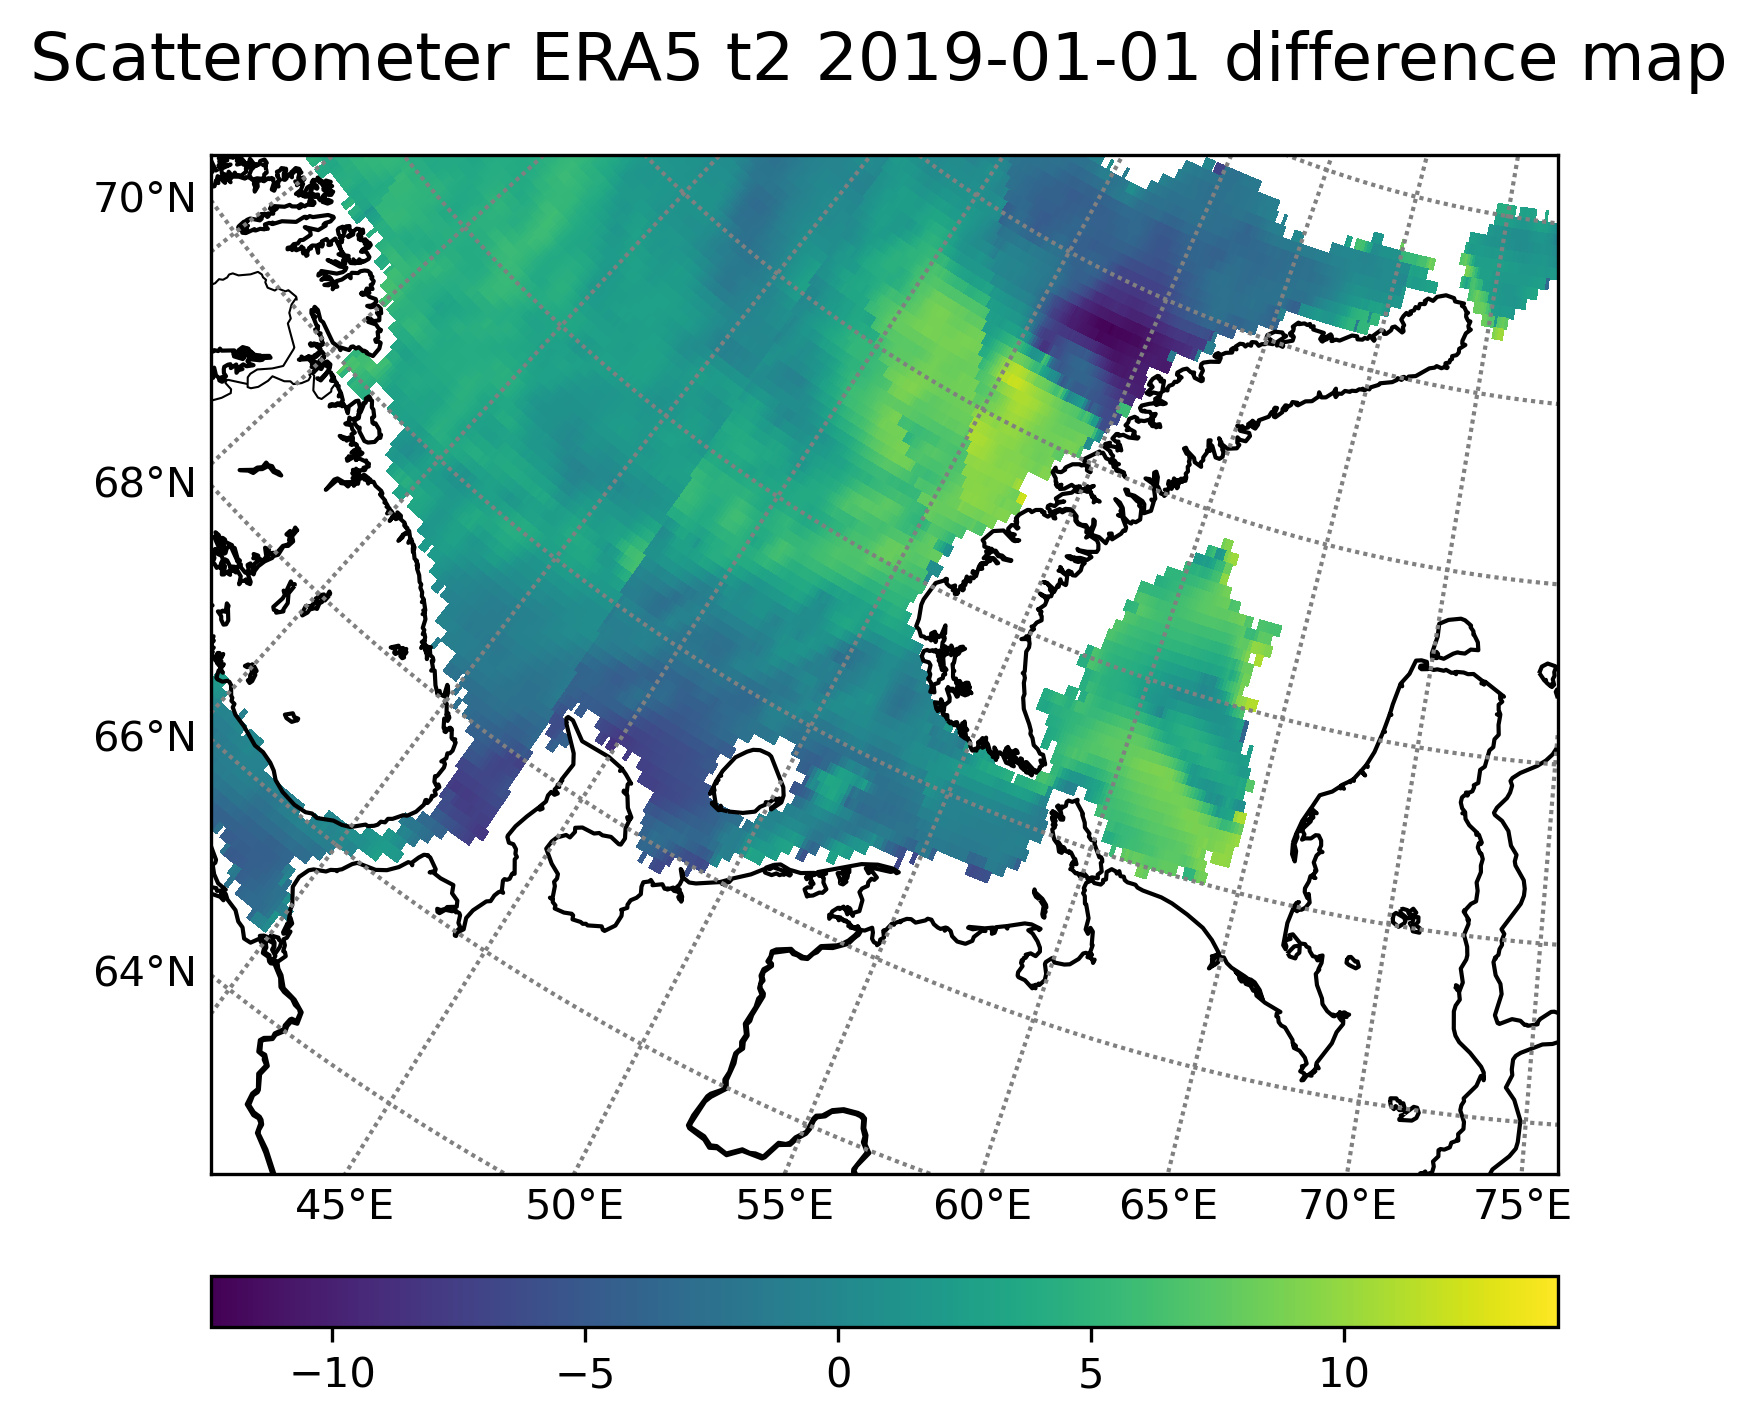

In [10]:
plot_utils.draw_borey_basemap(scatter[0, 0, 0], metadata['scat_yy'],metadata['scat_xx'], 'Scatterometer')

In [2]:
ts0 = pdl.parse('2020-01-01').timestamp()
ts1 = pdl.parse('2021-01-02').timestamp()

In [3]:
pdl.from_timestamp(ts1)

DateTime(2021, 1, 2, 0, 0, 0, tzinfo=Timezone('UTC'))

In [8]:
measurements_file = './stations/station_Pyalitsa_2019-01-01_2023-08-10.pkl'
station_files = find_files('./stations', '*')
names = []
coords = []
stations = []
for file in station_files:
    with open(file, 'rb') as f:
        measurements = pickle.load(f)
        names.append(measurements['Name'])
        coords.append(measurements['Coords'])
        stations.append(measurements['Station'])
stations = np.swapaxes(np.array(stations), 0, 1)
coords = np.array(coords)
coords[:, [0, 1]] = coords[:, [1, 0]]

In [49]:
broken_st = './stations/station_Sabetta_2019-01-01_2023-08-10.pkl'
with open(broken_st, 'rb') as f:
    measurements = pickle.load(f)
    print(measurements['Name'], measurements['Coords'], measurements['Station'])

# measurements['Station'].loc[:21919,'WSPD10'] = np.nan
# measurements['Station'].loc[:21919,'TC'] = np.nan
# measurements['Station'].loc[:21919,'PSFC'] = np.nan

# measurements_file = './stations/station_Sabetta_2019-01-01_2023-08-10.pkl'
# with open(measurements_file, 'wb') as f:
#     pickle.dump(measurements, f)

Sabetta (71.2156, 72.0462)           timestamp      TC   PSFC  WSPD10
0      1.625209e+09     NaN    NaN     NaN
1      1.625209e+09     NaN    NaN     NaN
2      1.625209e+09     NaN    NaN     NaN
3      1.625209e+09     NaN    NaN     NaN
4      1.625209e+09     NaN    NaN     NaN
...             ...     ...    ...     ...
40364  1.691611e+09  282.15  765.3     9.0
40365  1.691615e+09  282.15  765.3     8.0
40366  1.691618e+09  281.15  765.3     8.0
40367  1.691622e+09  281.15  766.1     7.0
40368  1.691626e+09  281.15  766.1     9.0

[40369 rows x 4 columns]


In [63]:
stations = torch.from_numpy(np.arange(9)).reshape([3, 3]).float()
pred_stations = torch.from_numpy(np.arange(9)).reshape([3, 3]).float()*2

stations[1, 1] = torch.nan
print(stations)

stations[torch.where(stations.isnan())] = pred_stations[torch.where(stations.isnan())]
stations

tensor([[0., 1., 2.],
        [3., nan, 5.],
        [6., 7., 8.]])


tensor([[0., 1., 2.],
        [3., 8., 5.],
        [6., 7., 8.]])

In [62]:
stations, stations.isnan()

(tensor([[0., 1., 2.],
         [3., nan, 5.],
         [6., 7., 8.]]),
 tensor([[False, False, False],
         [False,  True, False],
         [False, False, False]]))

In [25]:
curr = mes.iloc[0]['WSPD10']
for i in range(1, len(mes)):
    if mes.iloc[i]['WSPD10'] != curr:
        print(i)
        break
    curr =  mes.iloc[i]['WSPD10']
    

21920


In [45]:
mes.loc[:21920,'WSPD10'] = np.nan
mes.loc[:21920,'TC'] = np.nan
mes.loc[:21920,'PSFC'] = np.nan

In [47]:
mes[21920:]

timestamp      TC   PSFC  WSPD10
21920  1.625213e+09     NaN    NaN     NaN
21921  1.625216e+09  282.15  753.4    12.0
21922  1.625220e+09  281.15  753.4     8.0
21923  1.625224e+09  281.15  753.4     8.0
21924  1.625227e+09  281.15  752.6    11.0
...             ...     ...    ...     ...
40364  1.691611e+09  282.15  765.3     9.0
40365  1.691615e+09  282.15  765.3     8.0
40366  1.691618e+09  281.15  765.3     8.0
40367  1.691622e+09  281.15  766.1     7.0
40368  1.691626e+09  281.15  766.1     9.0

[18449 rows x 4 columns]

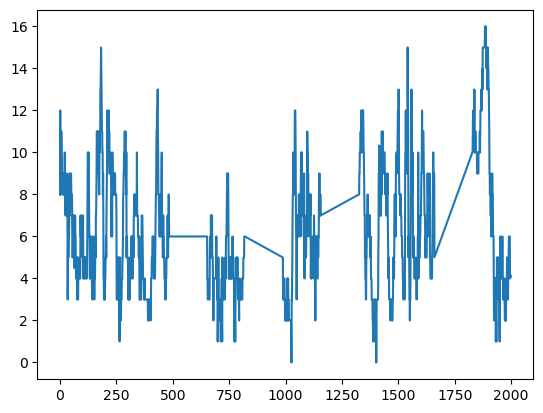

In [30]:
plt.plot(stations[21920:21920+2000, 35, 3])

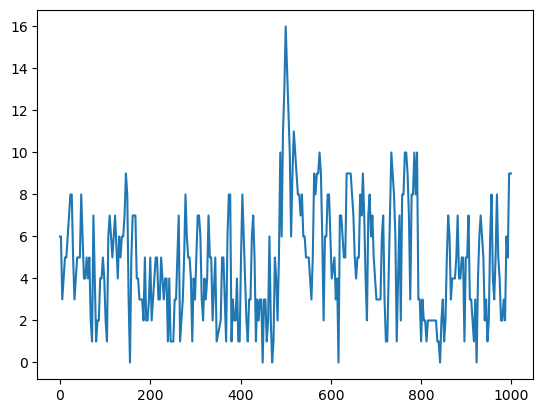

In [37]:
i= 4
plt.plot(stations[i*1000:i*1000+1000, 34, 3])

In [6]:
slice0 = np.where(stations[:, 0, 0] == ts0)[0][0]
slice1 = np.where(stations[:, 0, 0] == ts1)[0][0]
stations[slice0:slice1, 0, 0]

array([1.5778368e+09, 1.5778404e+09, 1.5778440e+09, ..., 1.6095348e+09,
       1.6095384e+09, 1.6095420e+09])

In [7]:
dates = stations[:, 0, 0]
slices = np.where((dates == ts0) | (dates == ts1))[0]
s = stations[slices[0]:slices[1]+24]

In [9]:
s[:, :, [1, 3]].shape

(8832, 46, 2)

In [83]:
pdl.from_timestamp(s[-1, 0, 0])

DateTime(2021, 1, 2, 23, 0, 0, tzinfo=Timezone('UTC'))

In [4]:
measurements['Station']

timestamp          TC        PSFC    WSPD10
0     1.662584e+09  278.550000  758.100000  3.000000
1     1.662588e+09  278.283333  758.166667  2.333333
2     1.662592e+09  278.016667  758.233333  1.666667
3     1.662595e+09  277.750000  758.300000  1.000000
4     1.662599e+09  277.750000  758.266667  1.333333
...            ...         ...         ...       ...
8063  1.691611e+09  291.016667  758.200000  4.000000
8064  1.691615e+09  290.350000  758.300000  4.000000
8065  1.691618e+09  289.950000  758.466667  4.333333
8066  1.691622e+09  289.550000  758.633333  4.666667
8067  1.691626e+09  289.150000  758.800000  5.000000

[8068 rows x 4 columns]

In [10]:
era_xx = np.load('./metadata/era_xx.npy')
era_yy = np.load('./metadata/era_yy.npy')
wrf_xx = np.load('./metadata/wrf_xx.npy')
wrf_yy = np.load('./metadata/wrf_yy.npy')

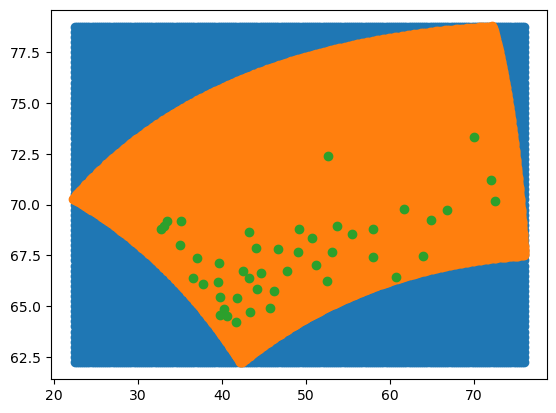

In [11]:
plt.scatter(era_xx, era_yy)
plt.scatter(wrf_xx, wrf_yy)
plt.scatter(coords[:,0], coords[:, 1])

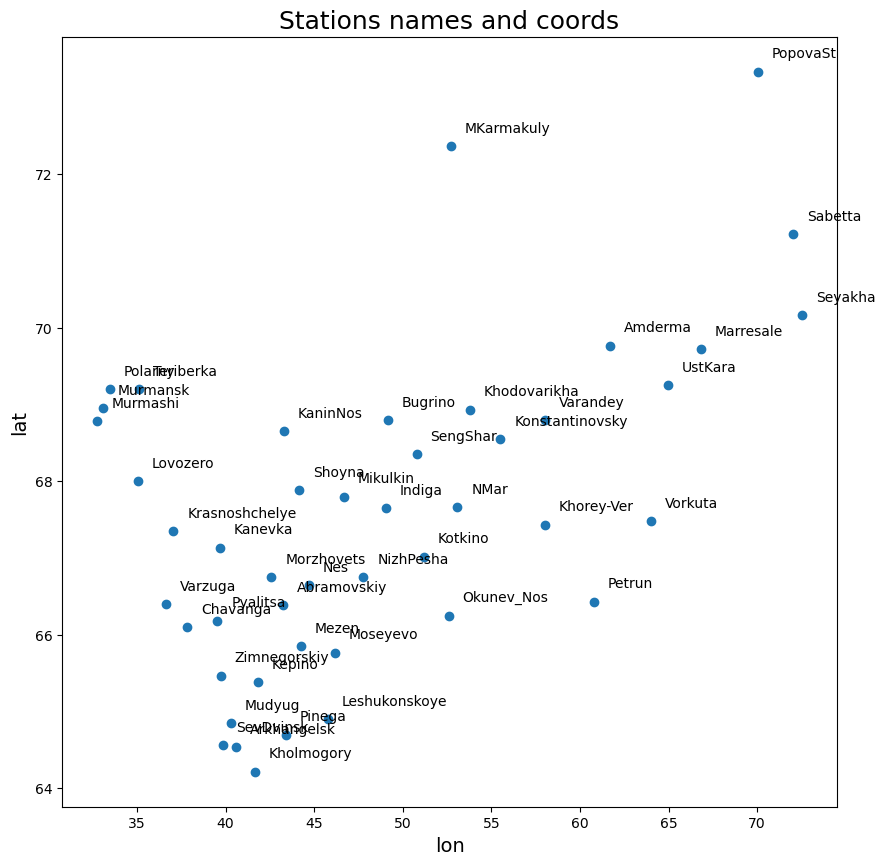

In [12]:
x = coords[:,0]
y = coords[:,1]

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(x, y)

ax.set_xlabel('lon', fontsize=14)
ax.set_ylabel('lat', fontsize=14)
ax.set_title('Stations names and coords', fontsize=18)

for i, txt in enumerate(names):
    ax.annotate(txt, (x[i], y[i]), xytext=(10,10), textcoords='offset points')
#     plt.scatter(x, y, marker='x', color='red')

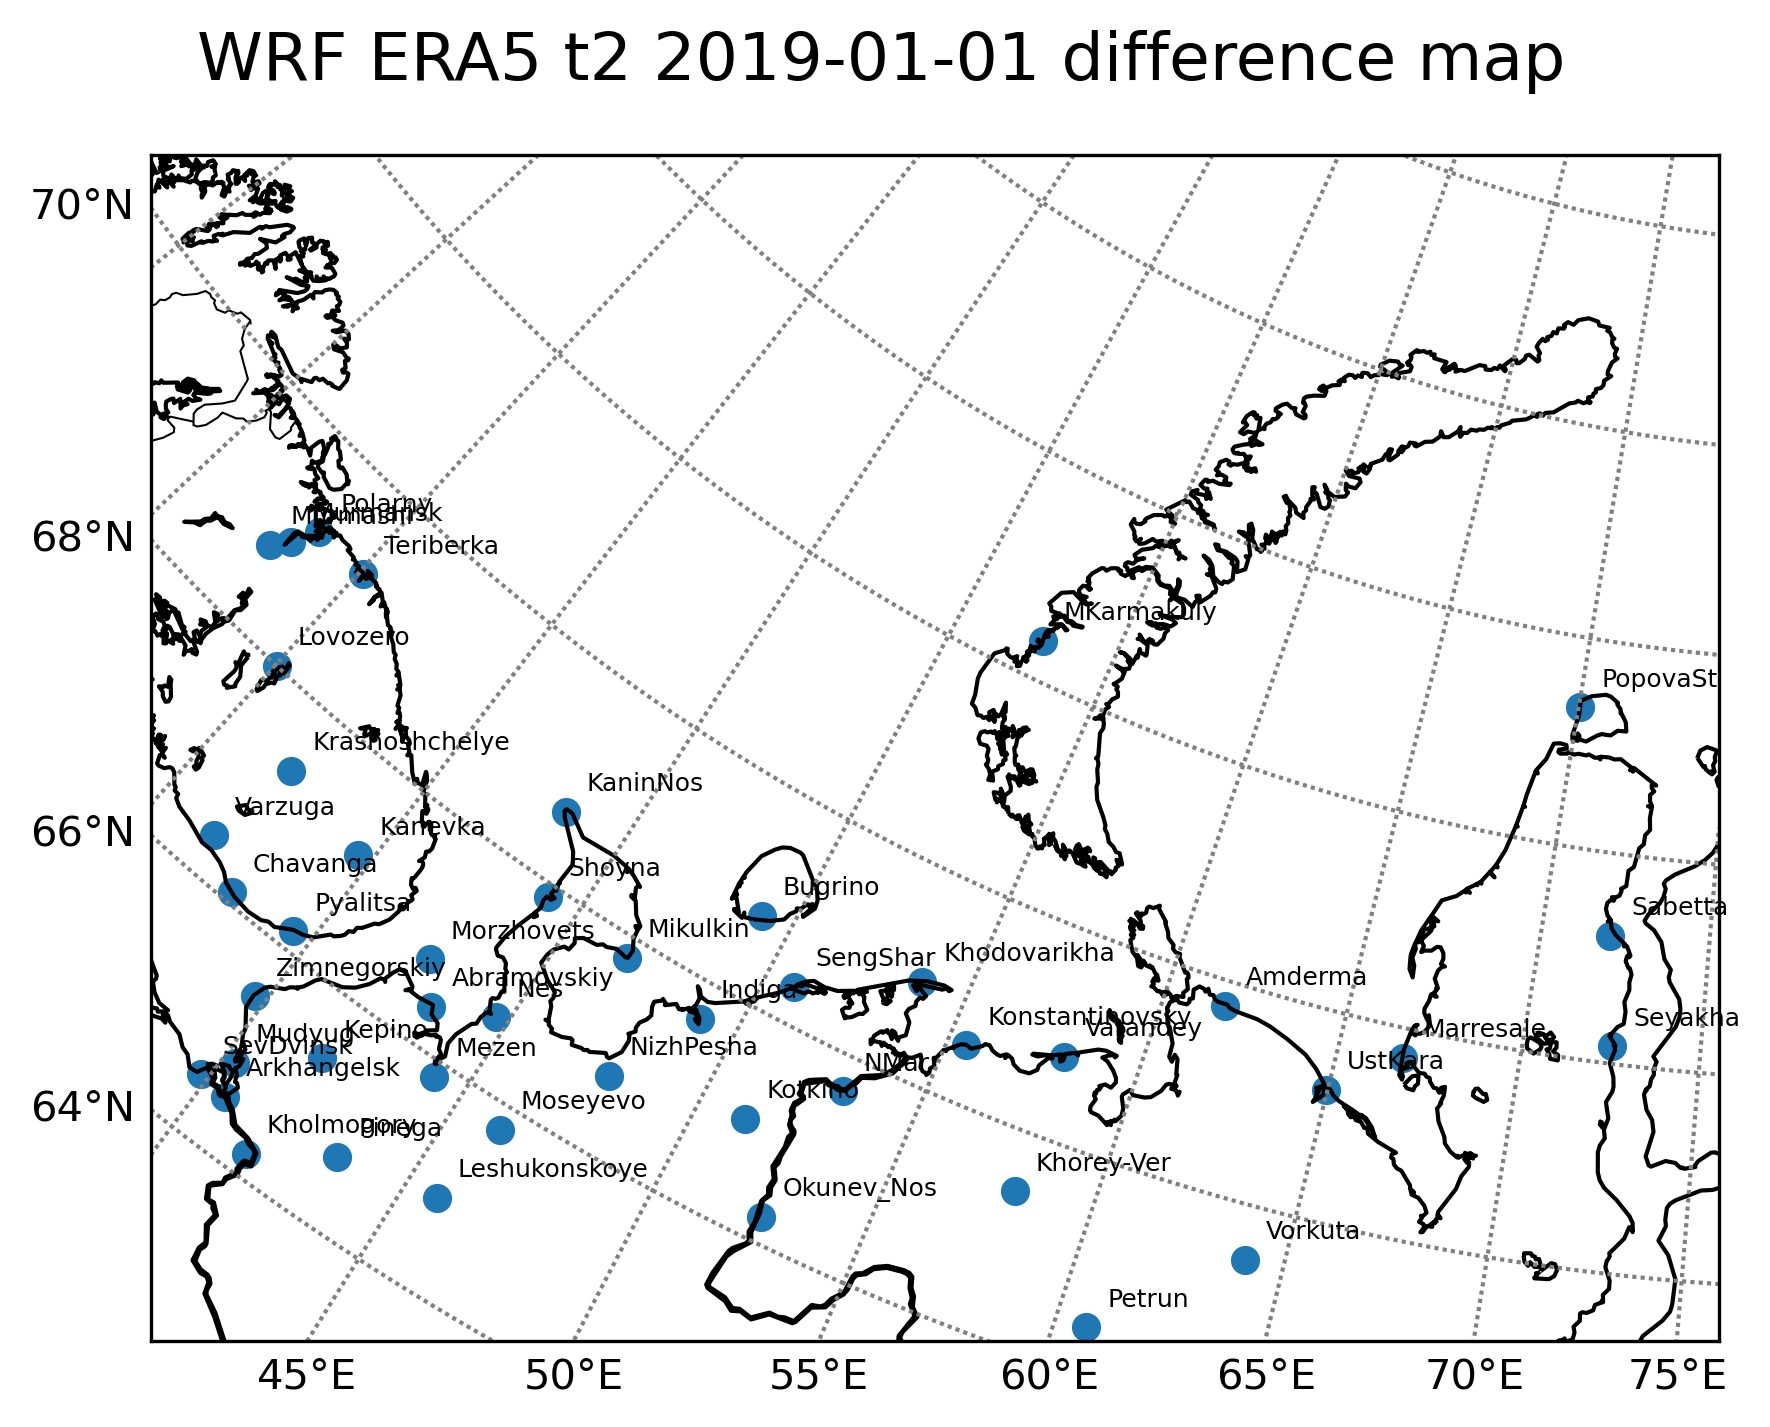

In [12]:
figs, ax, m = plot_utils.draw_borey_basemap(wrf[0, 0, 2], metadata['wrf_yy'],metadata['wrf_xx'], (coords[:,1], coords[:,0]))
m.scatter(*m(coords[:,0], coords[:,1]))
x, y = m(coords[:,0], coords[:,1])
for i, txt in enumerate(names):
    ax.annotate(names[i], (x[i], y[i]), xytext=(5,5), textcoords='offset points', fontsize=6)

In [7]:
measurements['Station'].sort_values('timestamp')['timestamp']
datetime.fromtimestamp(measurements['Station']['timestamp'][0]),datetime.fromtimestamp(measurements['Station']['timestamp'][8063])

(datetime.datetime(2022, 9, 8, 0, 0), datetime.datetime(2023, 8, 9, 23, 0))

In [8]:
wrf_folder = 'C:\\Users\\Viktor\\Desktop\\wrf_test'
era_folder = 'C:\\Users\\Viktor\\Desktop\\era_test'

test_file = find_files(wrf_folder, '*')[0]
test_file2 = find_files(era_folder, '*')[0]

# np.load()
import netCDF4
import wrf
with netCDF4.Dataset(test_file, 'r') as ncf:
    var = wrf.getvar(ncf, 'T2', wrf.ALL_TIMES, meta=False)
wrf_tensor = var.data[12]

with netCDF4.Dataset(test_file2, 'r') as ncf2:
    var = wrf.getvar(ncf2, 't2m', wrf.ALL_TIMES, meta=False)
era_tensor = var.data[12]

In [9]:
from scipy.interpolate import LinearNDInterpolator
import numpy as np
import matplotlib.pyplot as plt
grid = list(zip(wrf_xx.flatten(), wrf_yy.flatten()))
interp = LinearNDInterpolator(grid, wrf_tensor.flatten())
Z = interp(coords[:,0], coords[:,1])
Z

array([262.33319216, 257.97212117, 265.75457951, 264.81351046,
       272.10964431, 259.12009232, 263.92246896, 269.37877866,
       264.39800748, 262.42581921, 259.83234054, 258.1533907 ,
       258.93641135, 260.55217203, 264.51483751, 260.54365075,
       265.93836929, 266.52943272, 262.29044946, 258.547502  ,
       260.58172579, 258.94628721, 258.66981023, 266.4597481 ,
       258.99608803, 271.39069028, 257.60554202, 259.95488187,
       267.53774943, 259.30962201, 267.20638249, 270.21129251,
       258.18576594, 258.58962959, 265.3885496 , 269.69303164])

In [10]:
stations_sample = stations[:, :4, [1,3]]
stations_sample.shape

(36, 4, 2)

In [12]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Wedge
import matplotlib
import torch

In [13]:
a = torch.rand(32)*2 - 1
b = torch.rand(32)*2 - 1

C:\Users\Viktor\AppData\Local\Temp\ipykernel_9048\141319990.py:70: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  patches = [Arc((x_, y_), w_, h_, rot_, t1_, t2_)


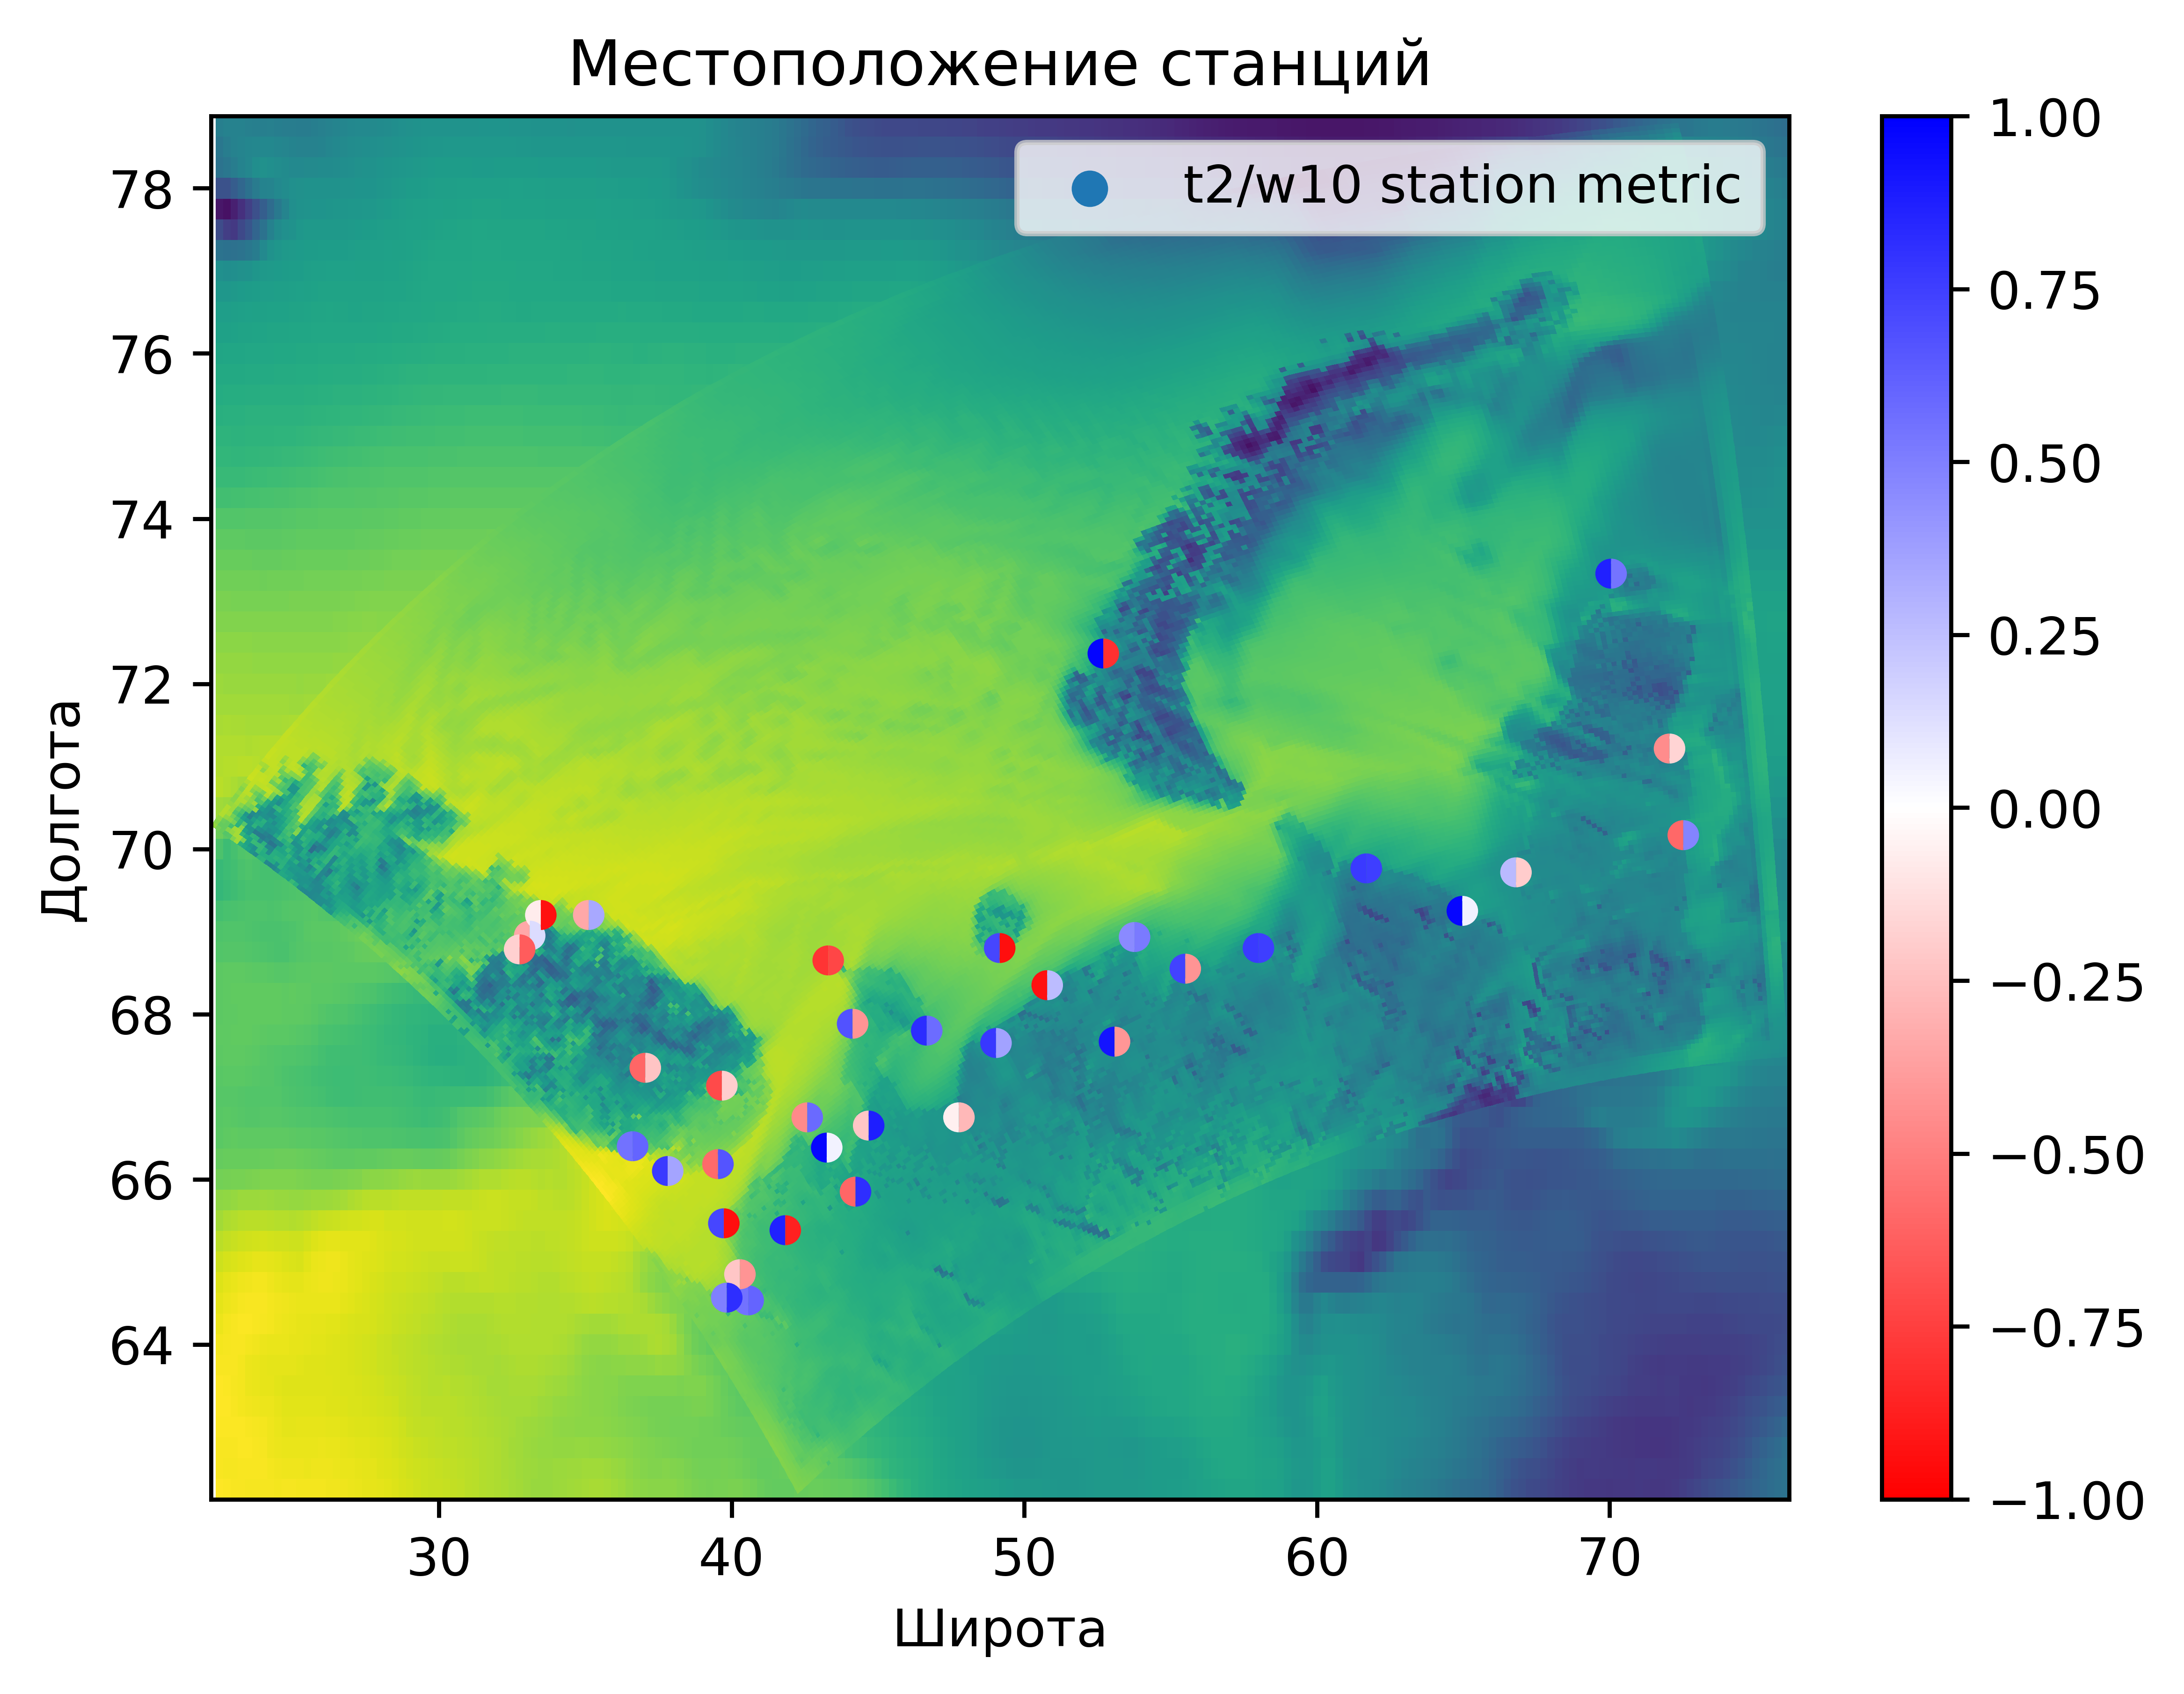

In [14]:


fig, ax = plt.subplots(dpi=800)
cmap = plt.cm.get_cmap('bwr_r')
norm = colors.Normalize(vmin=-1, vmax=1)
plt.scatter(coords[:,0], coords[:,1], label='t2/w10 station metric')
plt.pcolormesh(era_xx, era_yy, era_tensor, shading='auto')

plt.pcolormesh(wrf_xx, wrf_yy, wrf_tensor, shading='auto')


theta1, theta2 = 90, 90 + 180
radius = 0.3
center = (0, 0)
size = fig.get_size_inches()*fig.dpi 

arcs(coords[:,0], coords[:,1], 3*radius, radius, theta1=90, theta2=270,color=cmap(norm(a)))
arcs(coords[:,0], coords[:,1], 3*radius, radius, theta1=270, theta2=90, color=cmap(norm(b)))

plt.title('Местоположение станций')
plt.xlabel('Широта')
plt.ylabel('Долгота')
plt.legend()

fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax,orientation='vertical', fraction=0.1)


In [15]:
import torch
def get_distances_matrix(a, b):
    r = torch.mm(a.t(), b)
    r1 = torch.mm(a.t(), a)
    diag1 = r1.diag().unsqueeze(1)
    diag1 = diag1.expand_as(r)
    r2 = torch.mm(b.t(), b)
    diag2 = r2.diag().unsqueeze(0)
    diag2 = diag2.expand_as(r)
    D = (diag1 + diag2 - 2 * r).sqrt()
    return D

In [1]:
import numpy as np
from correction.models.changeToERA5 import MeanToERA5 

In [2]:
mapping = np.load('wrferaMapping.npy')
wxx = np.flip(np.load('metadata/wrf_xx.npy'), 0)
wyy = np.flip(np.load('metadata/wrf_yy.npy'), 0)
exx = np.load('metadata/era_xx.npy')
eyy = np.load('metadata/era_yy.npy')

In [3]:
np.save('metadata/wrf_xx.npy', wxx)
np.save('metadata/wrf_yy.npy', wyy)

In [19]:
wxx

array([[22.318695, 22.411926, 22.505524, ..., 71.68228 , 71.95456 ,
        72.22717 ],
       [22.449432, 22.542786, 22.636536, ..., 71.71973 , 71.990845,
        72.26224 ],
       [22.579742, 22.673248, 22.76715 , ..., 71.75687 , 72.026764,
        72.297   ],
       ...,
       [42.139435, 42.233063, 42.326904, ..., 75.711426, 75.85306 ,
        75.99475 ],
       [42.20688 , 42.300446, 42.394196, ..., 75.721466, 75.86276 ,
        76.00412 ],
       [42.27414 , 42.367615, 42.461304, ..., 75.731445, 75.872406,
        76.01343 ]], dtype=float32)

In [5]:
wrf = np.stack((wxx.flatten(), wyy.flatten()))
era = np.stack((exx.flatten(), eyy.flatten()))

In [6]:
nearest = torch.topk(get_distances_matrix(torch.tensor(wrf), torch.tensor(era)), 1, 1, largest=False)

In [7]:
nearest.values

tensor([[0.1822],
        [0.1169],
        [0.1250],
        ...,
        [0.0000],
        [0.1169],
        [0.0000]])